# CAP Curve with Weighted Gini

Demonstrates:

- Weighted Gini coefficient for binary classification
- Multiple model comparison on same plot
- Custom colormap support
- Flexible grid layouts


In [6]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.ensemble import (
    GradientBoostingClassifier,
    RandomForestClassifier,
    RandomForestRegressor,
)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from fastwoe.plots import plot_performance

%config InlineBackend.figure_format = 'retina'

## 1. Generate Credit Risk Data


In [7]:
# Generate sample data
n = 10000

df = pd.DataFrame(
    {
        "age": np.random.randint(18, 75, n),
        "income": np.random.lognormal(10.5, 0.8, n),
        "credit_score": np.random.randint(300, 850, n),
        "debt_to_income": np.random.uniform(0, 1.5, n),
    }
)

# Binary target (default indicator)
default_prob = 1 / (
    1
    + np.exp(
        5
        - 0.01 * (df["credit_score"] - 500)
        - 0.5 * np.log(df["income"] / 30000)
        + 2 * df["debt_to_income"]
    )
)
y = np.random.binomial(1, default_prob)

# Exposure at Default (EAD weights)
ead = np.random.lognormal(10, 1.5, n)

print(f"Dataset: {n:,} samples")
print(f"Default rate: {y.mean():.2%}")
print(f"Total EAD: ${ead.sum():,.0f}")

Dataset: 10,000 samples
Default rate: 1.50%
Total EAD: $659,967,653


## 2. Train Multiple Models


In [8]:
# Split data
X_train, X_test, y_train, y_test, ead_train, ead_test = train_test_split(
    df, y, ead, test_size=0.3, random_state=42
)

# Train 3 different models
models = {
    "Logistic": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42),
}

predictions = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions[name] = model.predict_proba(X_test)[:, 1]
    print(f"✓ {name} trained")

✓ Logistic trained
✓ Random Forest trained
✓ Gradient Boosting trained


## 3. Single Model - Unweighted Gini


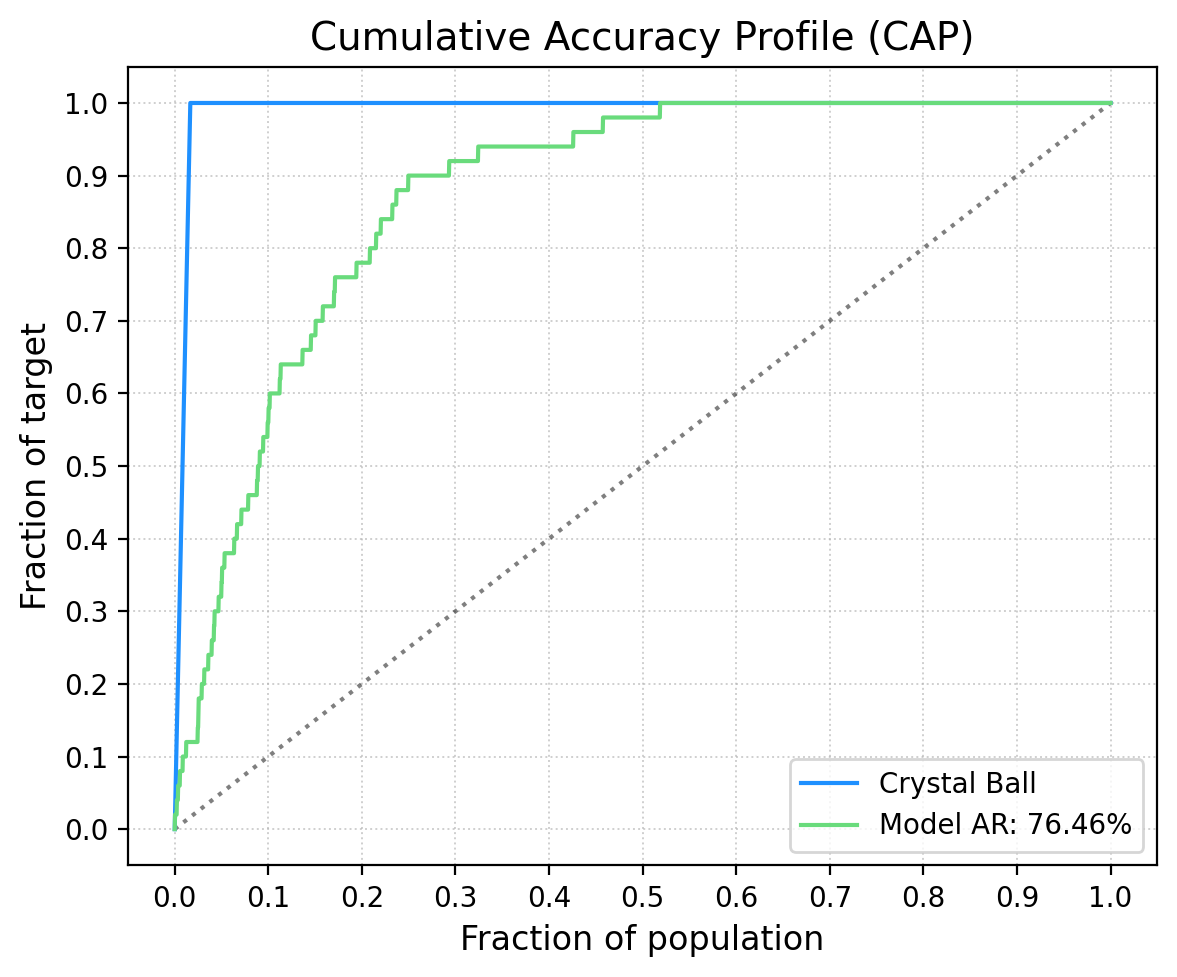

Gini (unweighted): 0.7646


In [9]:
fig, ax, gini = plot_performance(y_true=y_test, y_pred=predictions["Logistic"])

print(f"Gini (unweighted): {gini:.4f}")

## 4. Single Model - EAD-Weighted Gini

For credit risk models, EAD weighting ensures larger exposures have more influence.


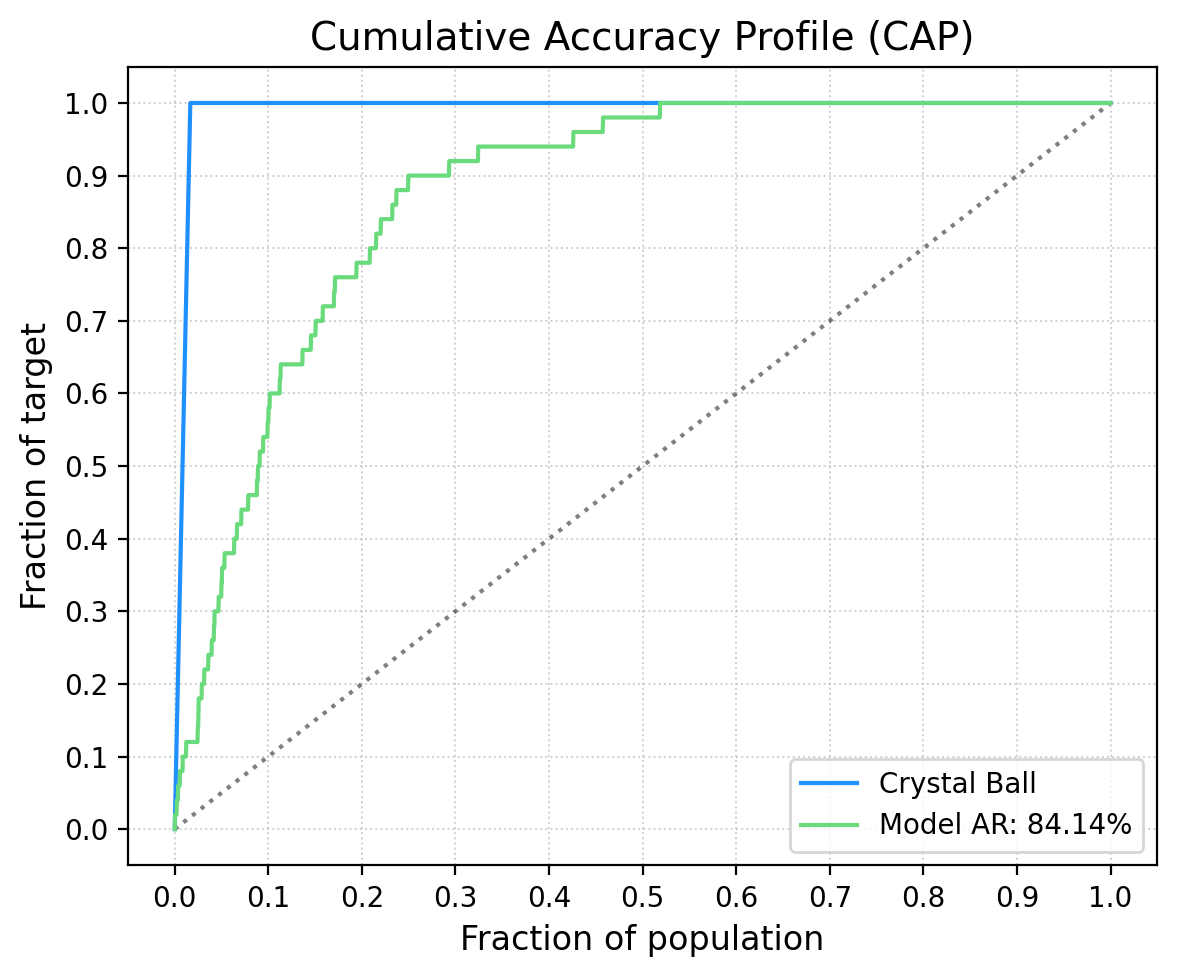

Gini (EAD-weighted): 0.8414
Difference: +0.0767


In [10]:
fig, ax, gini_weighted = plot_performance(
    y_true=y_test,
    y_pred=predictions["Logistic"],
    weights=ead_test,  # ← EAD weights
)

print(f"Gini (EAD-weighted): {gini_weighted:.4f}")
print(f"Difference: {gini_weighted - gini:+.4f}")

## 5. Compare Multiple Models

Plot all models on the same chart with automatic color assignment.


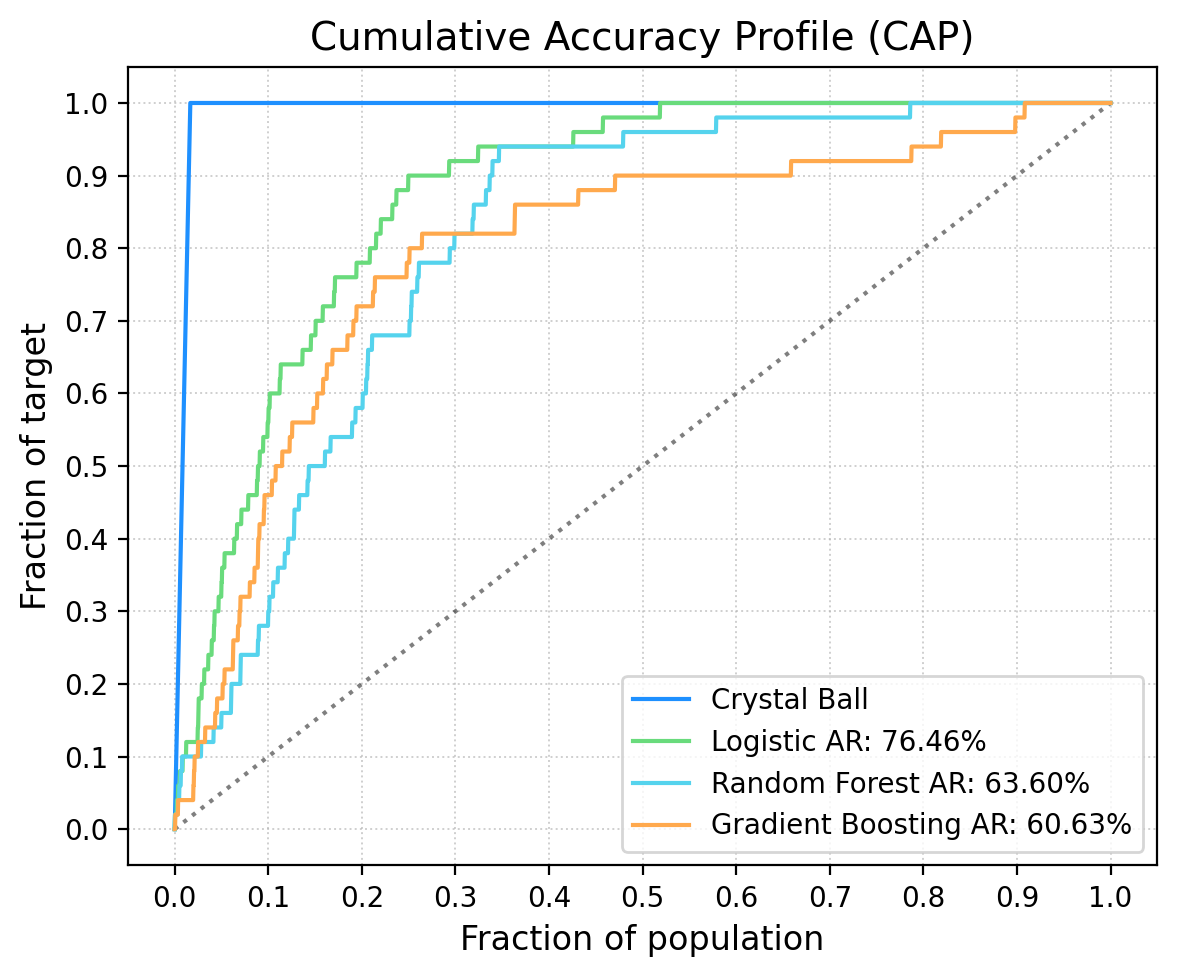

In [ ]:
fig, ax, ginis = plot_performance(
    y_true=y_test,
    y_pred=[
        predictions["Logistic"],
        predictions["Random Forest"],
        predictions["Gradient Boosting"],
    ],
    labels=["Logistic", "Random Forest", "Gradient Boosting"],
)

## 6. Custom Colormap

Use custom colors for your models.


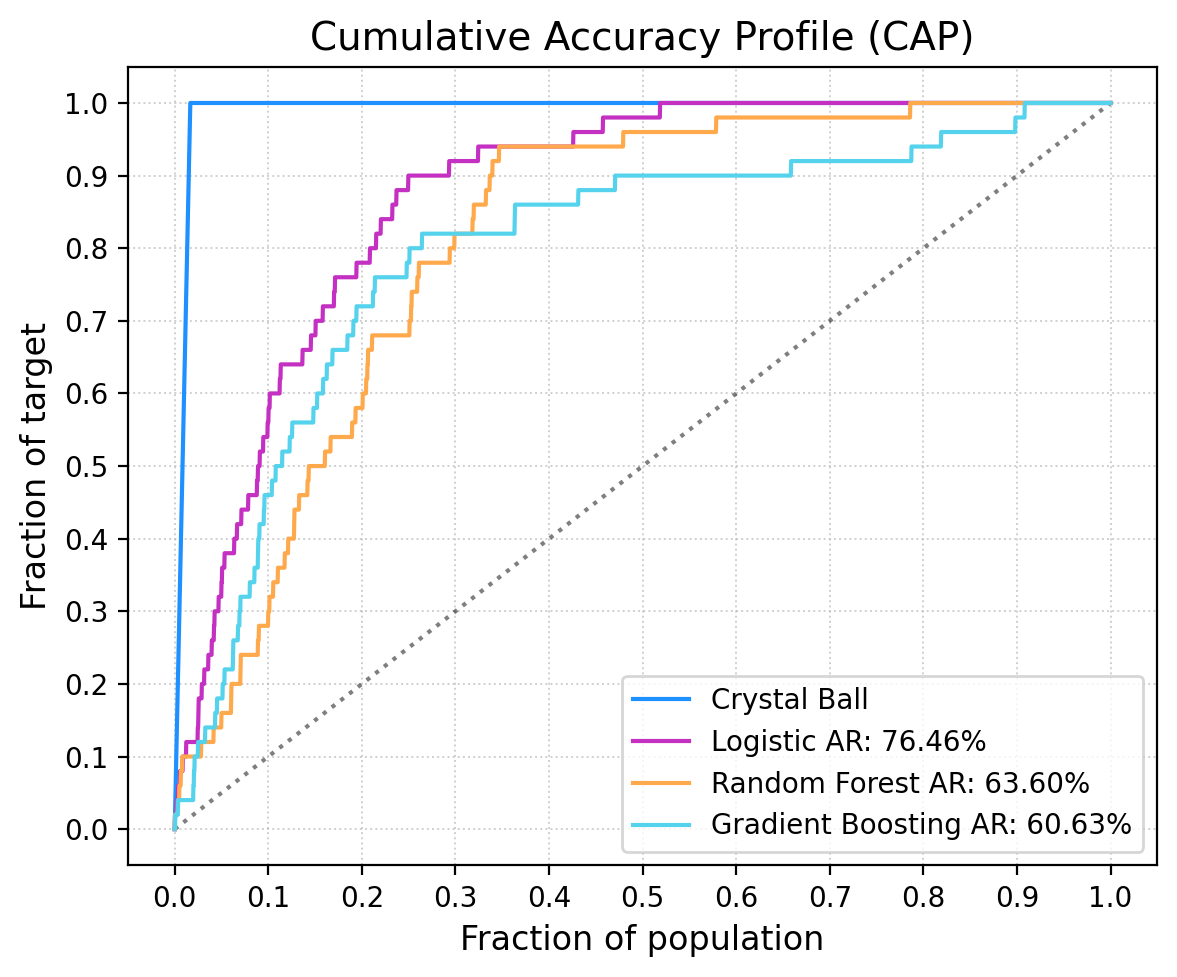

In [13]:
# Custom colors
custom_colors = ["#c430c1", "#ffa94d", "#55d3ed"]

fig, ax, ginis = plot_performance(
    y_true=y_test,
    y_pred=[
        predictions["Logistic"],
        predictions["Random Forest"],
        predictions["Gradient Boosting"],
    ],
    labels=["Logistic", "Random Forest", "Gradient Boosting"],
    colors=custom_colors,  # ← Custom colors
)

## 7. Multiple Models with EAD Weighting

Compare models using EAD-weighted Gini.


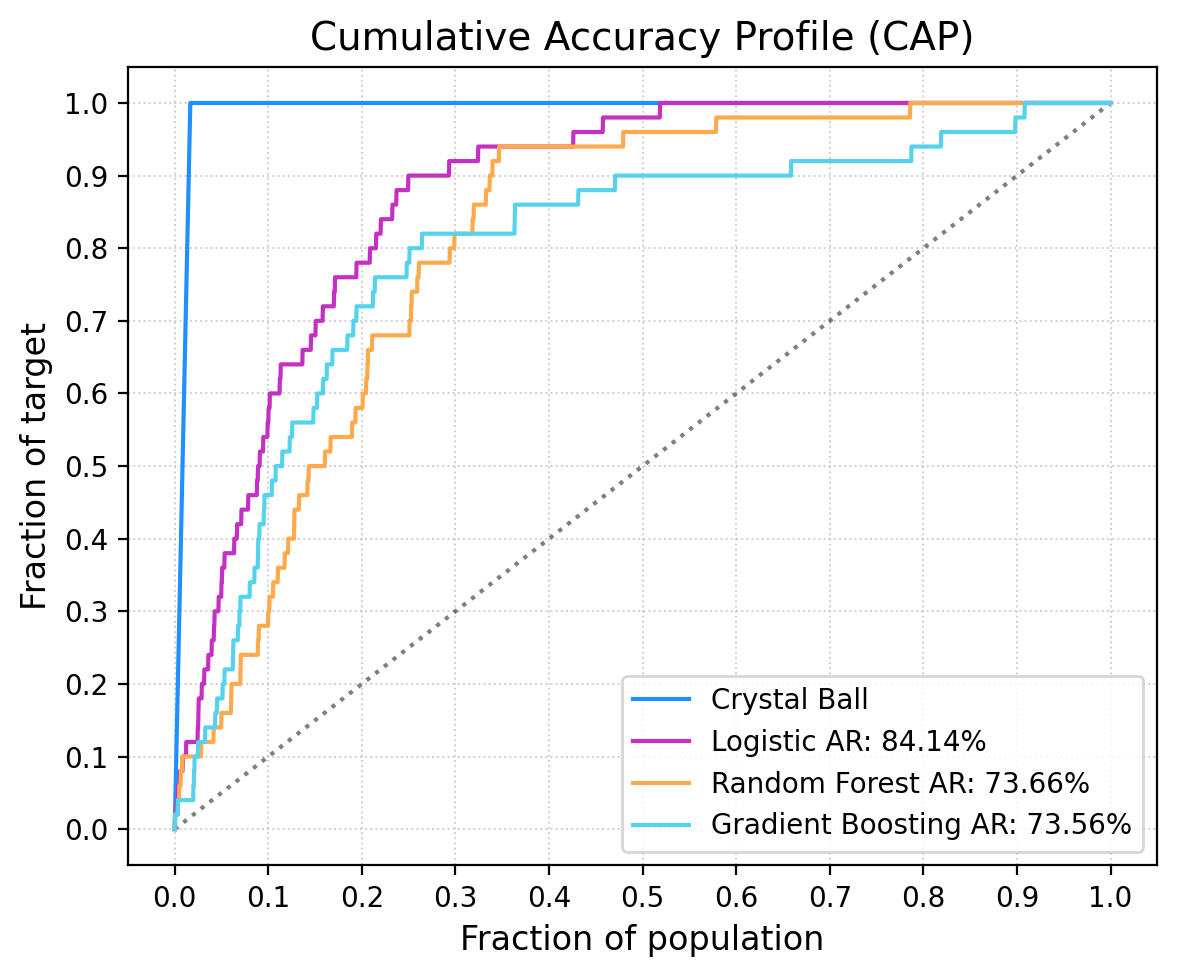

In [15]:
fig, ax, ginis_weighted = plot_performance(
    y_true=y_test,
    y_pred=[
        predictions["Logistic"],
        predictions["Random Forest"],
        predictions["Gradient Boosting"],
    ],
    weights=ead_test,  # ← EAD weights
    labels=["Logistic", "Random Forest", "Gradient Boosting"],
    colors=custom_colors,
)

## 8. Side-by-Side Comparison

Create custom grid layouts to compare unweighted vs weighted Gini.


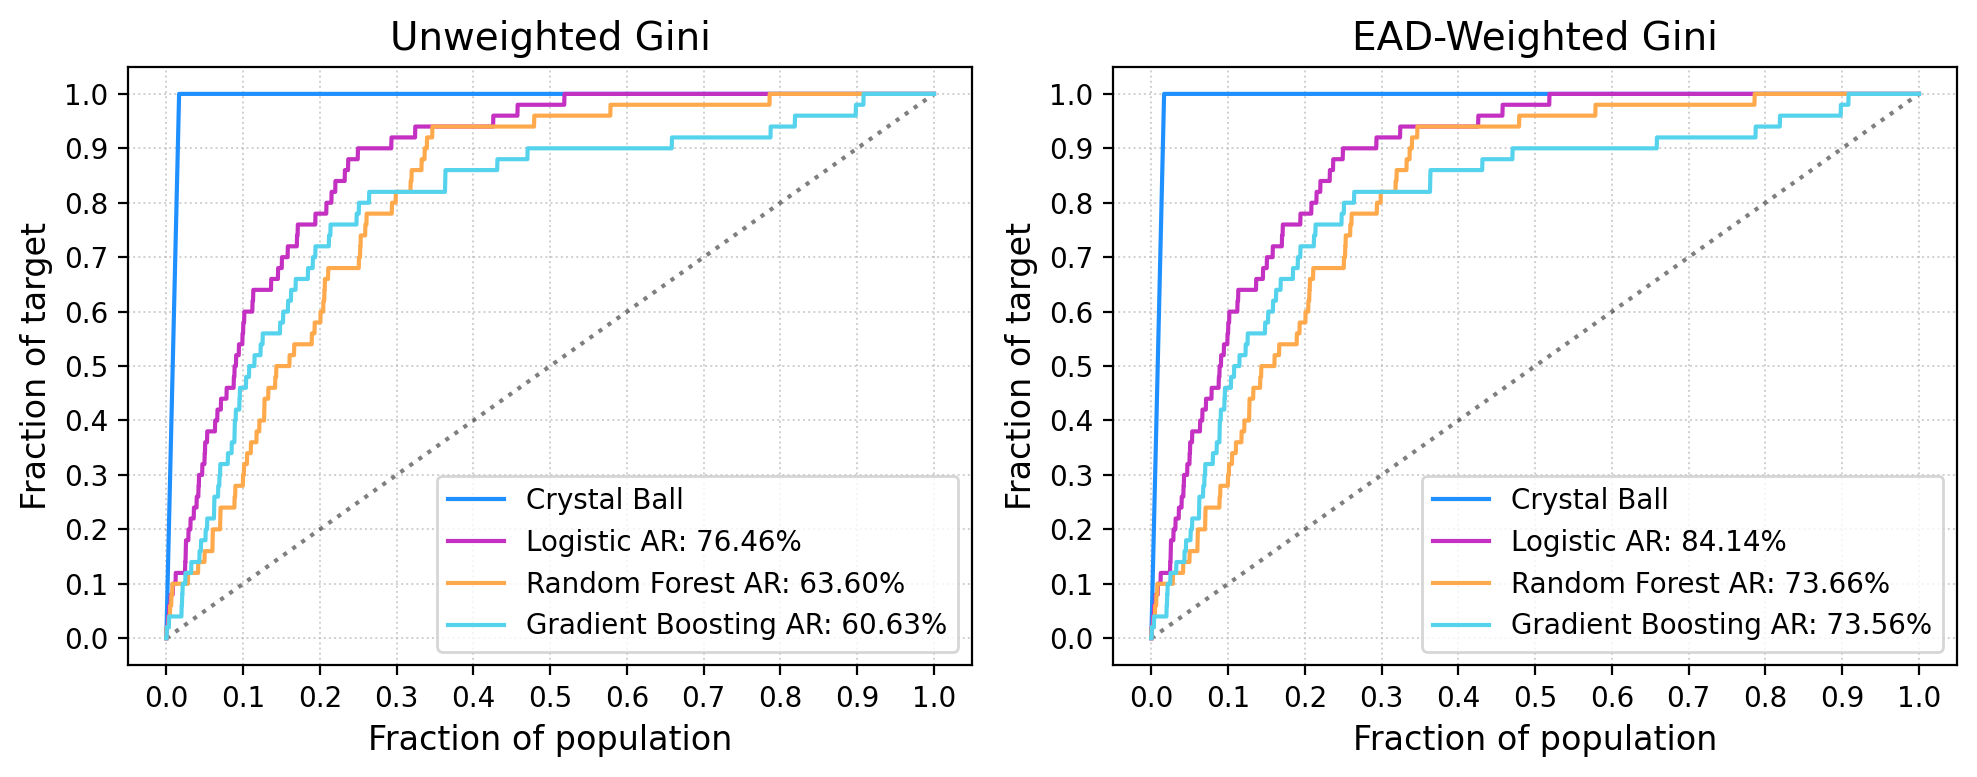

In [17]:
# Create 1x2 grid
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Left: Unweighted
_, _, ginis_unw = plot_performance(
    y_test,
    [
        predictions["Logistic"],
        predictions["Random Forest"],
        predictions["Gradient Boosting"],
    ],
    ax=ax1,
    labels=["Logistic", "Random Forest", "Gradient Boosting"],
    colors=custom_colors,
)
ax1.set_title("Unweighted Gini", fontsize=14)

# Right: EAD-Weighted
_, _, ginis_w = plot_performance(
    y_test,
    [
        predictions["Logistic"],
        predictions["Random Forest"],
        predictions["Gradient Boosting"],
    ],
    weights=ead_test,
    ax=ax2,
    labels=["Logistic", "Random Forest", "Gradient Boosting"],
    colors=custom_colors,
)
ax2.set_title("EAD-Weighted Gini", fontsize=14)

plt.tight_layout()
plt.show()

## 9. Continuous Target - LGD Model

Demonstrates Power Curve for Loss Given Default (LGD) models.


In [18]:
# Generate continuous target (LGD)
y_lgd = np.clip(
    0.45 + 0.3 * df["debt_to_income"] - 0.0002 * df["credit_score"] + np.random.normal(0, 0.05, n),
    0,
    1,
)

# Split data
X_train_lgd, X_test_lgd, y_train_lgd, y_test_lgd, ead_train_lgd, ead_test_lgd = train_test_split(
    df, y_lgd, ead, test_size=0.3, random_state=42
)

# Train LGD model
model_lgd = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42)
model_lgd.fit(X_train_lgd, y_train_lgd)
y_pred_lgd = model_lgd.predict(X_test_lgd)
y_pred_lgd = np.clip(y_pred_lgd, 0, 1)

print(f"Mean LGD: {y_test_lgd.mean():.2%}")

Mean LGD: 55.97%


### 9.1 LGD Power Curve - Unweighted


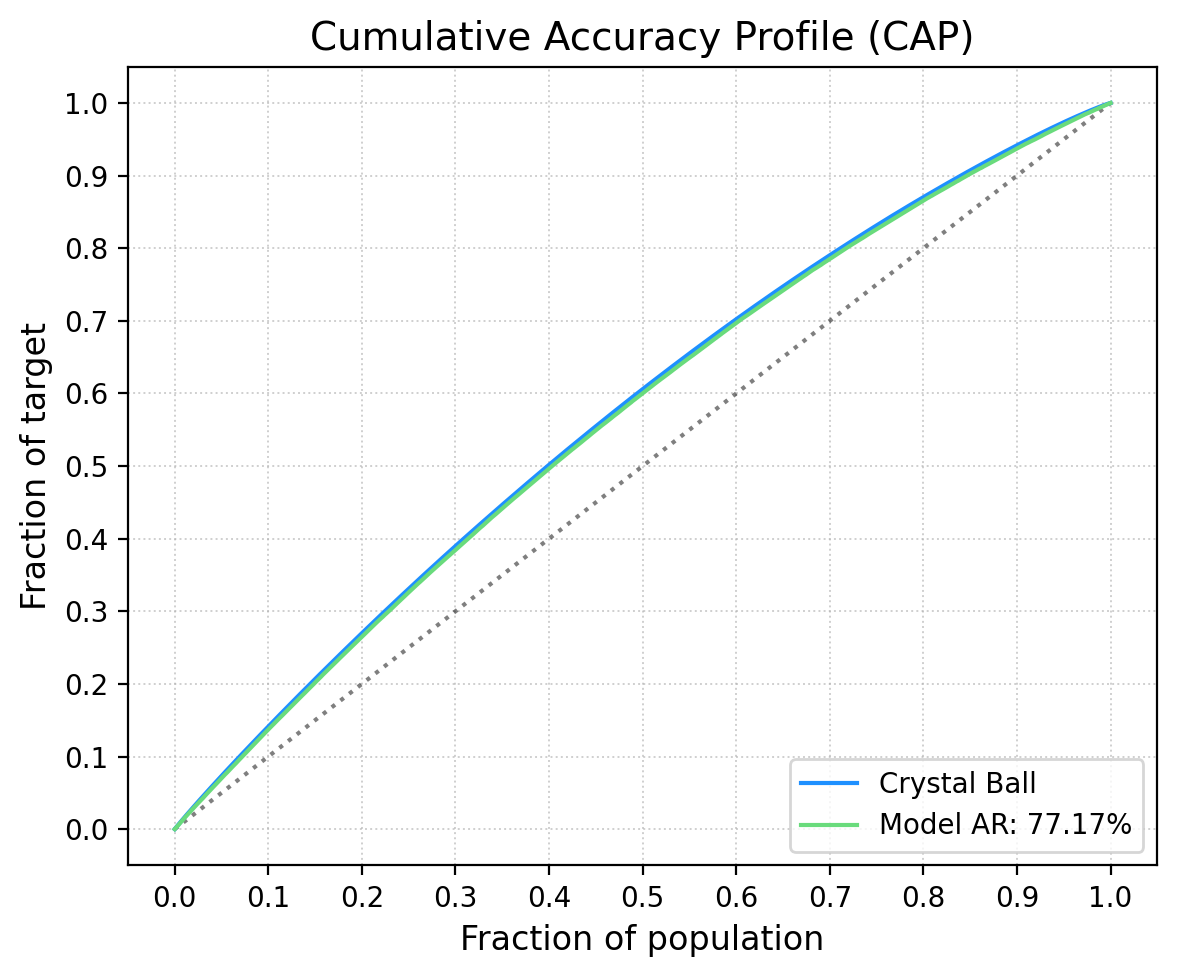

LGD Gini (unweighted): 0.7717


In [19]:
fig, ax, gini_lgd = plot_performance(y_true=y_test_lgd, y_pred=y_pred_lgd)

print(f"LGD Gini (unweighted): {gini_lgd:.4f}")

### 9.2 LGD Power Curve - EAD-Weighted

For LGD models, EAD weighting is essential for Basel/regulatory compliance.


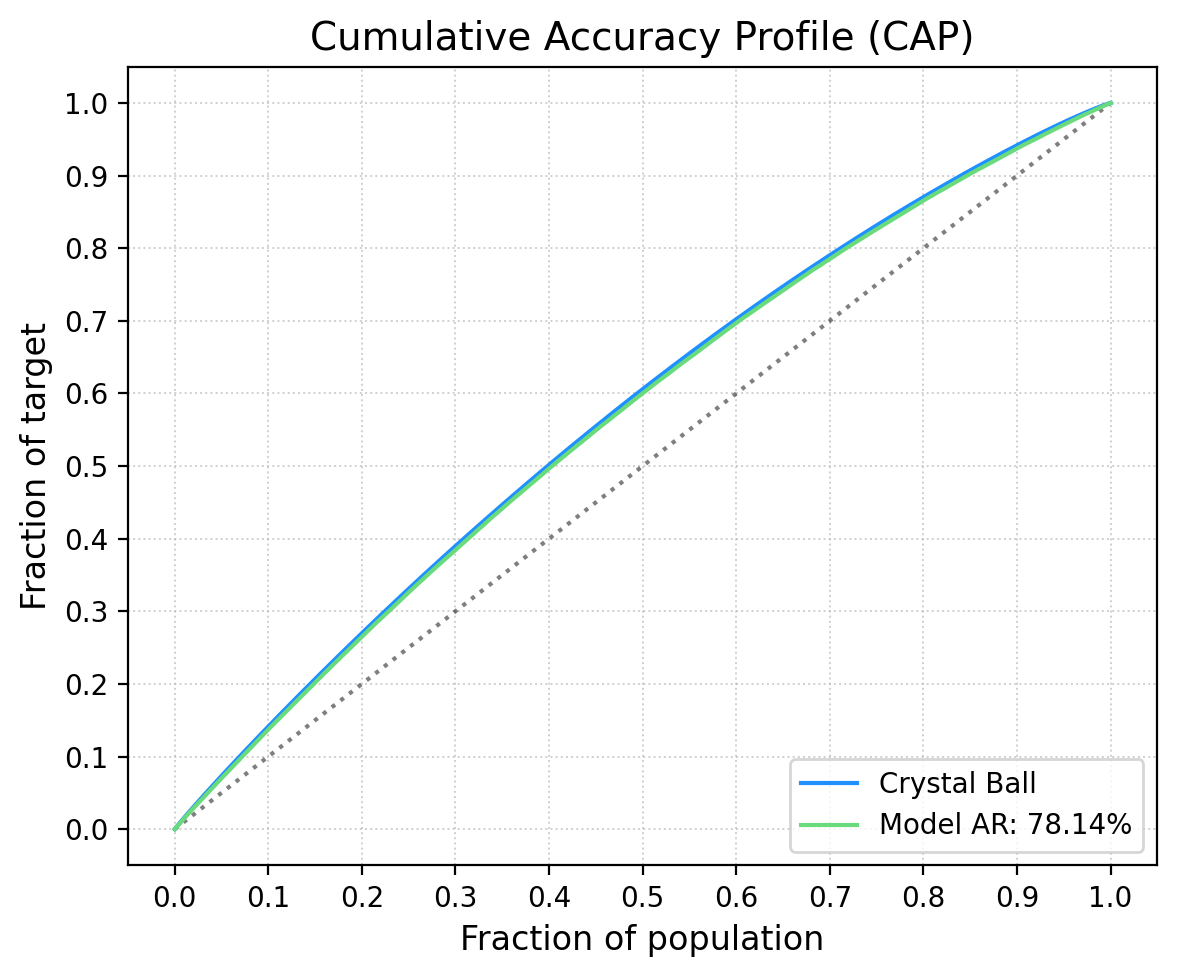

LGD Gini (EAD-weighted): 0.7814
Difference: +0.0097


In [20]:
fig, ax, gini_lgd_weighted = plot_performance(
    y_true=y_test_lgd,
    y_pred=y_pred_lgd,
    weights=ead_test_lgd,
)

print(f"LGD Gini (EAD-weighted): {gini_lgd_weighted:.4f}")
print(f"Difference: {gini_lgd_weighted - gini_lgd:+.4f}")